In [1]:
import datetime as dt
import requests
import pandas as pd
import os
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from nltk.corpus import stopwords
from nltk.stem.porter import *
import re
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, Attention, Input
from tensorflow.keras.metrics import Precision, Recall
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pickle

In [ ]:
#The sample of news we will use to test of model
df= pd.DataFrame({"title":['El 97 % del Oro Verde Portoviejo ya está construido y en junio abrirá su sistema de reservas',
'Apertura comercial y nuevos mercados, termas que abordaron empresarios y el Ministro de Producción, en Quito',
'En qué provincias de Ecuador ya mismo “muere” la televisión pagada: en siete años se perdieron cerca de 400 suscriptores por día',
'Productores y compradores de café de especialidad negociaron sin intermediarios, en Imbabura',
'Hasta finales de junio Ecuador busca cerrar negociación con Estados Unidos por arancel del 10 %',
'Estas son las empresas privadas que proveen internet y servicios tecnológicos con más ingresos en Ecuador: Claro lidera el listado',
'Seguros Equinoccial y Ecuatoriano Suiza concretan su integración en el mercado nacional',
'FMI, Banco Mundial y BID están en Ecuador para “reforzar apoyo financiero y técnico ante inicio de nuevo periodo de gobierno”',
'Televisión pagada: Presidente de Liga Pro apela a la unión de varios sectores paga combatir la piratería de contenidos',
'Riesgo país vuelve a bajar por debajo de los 1.000 puntos']})

In [2]:
#The API that will give us the daily news
load_dotenv("tokens.env") 
API_KEY= os.getenv("API_KEY")

#Process the data and only keep the headers of the news
data= requests.get(f'https://newsdata.io/api/1/latest?apikey={API_KEY}&q=ecuador&country=ec&category=business')
data= data.json()



In [3]:
if data["status"] != "error":
    df= pd.DataFrame(data["results"])
    df.drop(columns=["keywords","content","image_url","video_url","source_icon","language","country","sentiment","sentiment_stats","ai_tag","ai_region","ai_org"],inplace=True)
    df["title"]
else:
    print("No funciono bien")

In [4]:
from googletrans import Translator
import time

translator = Translator()

#Function that translate the news and create a new column of the translated news
def translate_text(text):
    try:
        time.sleep(1)
        return translator.translate(text, src='es', dest='en').text
    except Exception as e:
        print("Error:", e)
        return ""

df["title"] = df["title"].apply(translate_text)

In [5]:
filtered= df[["article_id","title","link","pubDate"]]

In [6]:
header= {
    "Authorization": "Bearer EVENIF"
}

In [14]:
filtered["article_id"]

0    a061dba76703f0e6789cd629adc60da4
1    62b50ad4f606222e615ce8bd772cb488
2    92b506dc2e205d74c2f695031e686c0d
3    c585972e943b165915928712fe7b49bd
4    7473ef273d337505af717488d8794481
Name: article_id, dtype: object

In [16]:
for i in range(filtered.shape[0]):
    final= {"main":{
                "articleid":filtered["article_id"].to_list()[i],
                "title":filtered["title"].to_list()[i],
                "link":filtered["link"].to_list()[i],
                "pubDate":filtered["pubDate"].to_list()[i],
                },
            }
    response= requests.post("https://api.sheety.co/dd0fd7bbef359aae1247a81f76b6d24f/dataBfn/main",json=final,headers=header)
    print(response.status_code)

200
200
200
200
200


In [6]:
from googletrans import Translator
import time

translator = Translator()

#Function that translate the news and create a new column of the translated news
def translate_text(text):
    try:
        time.sleep(1)
        return translator.translate(text, src='es', dest='en').text
    except Exception as e:
        print("Error:", e)
        return ""

df["title_en"] = df["title"].apply(translate_text)

In [ ]:
#Import the data
MAIN_RT= 'D:\\DatosFN'

data= pd.read_csv(f"{MAIN_RT}\\all-data.csv",encoding="latin1")
data2= pd.read_csv(f"{MAIN_RT}\\data.csv",encoding="latin1")

In [3]:
print(data.shape)
print(data["neutral"].unique())
print(data2.shape)
print(data2["Sentiment"].unique())

(4845, 2)
['neutral' 'negative' 'positive']
(5842, 2)
['positive' 'negative' 'neutral']


In [ ]:
#Clean the dataframe
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)
data2.drop_duplicates(inplace=True)
data2.dropna(inplace=True)
data.columns= ["Sentiment","Sentence"]
dtf= pd.concat([data2,data])

In [ ]:

# Resample each class with the value of the minoritary class
min_count = min(len(dtf[dtf["Sentiment"] == s]) for s in ["neutral", "positive", "negative"])
dtf = pd.concat([
    resample(dtf[dtf["Sentiment"] == "neutral"], replace=False, n_samples=min_count, random_state=1),
    resample(dtf[dtf["Sentiment"] == "positive"], replace=False, n_samples=min_count, random_state=1),
    resample(dtf[dtf["Sentiment"] == "negative"], replace=False, n_samples=min_count, random_state=1)
])

In [11]:
#ONLY download once if you are using your own enviroment
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to C:\Users\tolgu.LAPTOP-
[nltk_data]     6G833A4V\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\tolgu.LAPTOP-
[nltk_data]     6G833A4V\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [19]:
#Transform all the words to the basic form with PorterStemmer, eliminating stopwords and tokenizing each

stop_words = set(stopwords.words("english"))
def basicalizer(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = word_tokenize(text)
    words = [w for w in words if w not in stop_words]
    words = [PorterStemmer().stem(w) for w in words]
    return ' '.join(words)

In [ ]:
#One hot encode the sentiments
y= pd.get_dummies(dtf["Sentiment"])

In [ ]:
#Tokenize again and make pad_sequences of words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(dtf["Sentence"])

X = tokenizer.texts_to_sequences(dtf["Sentence"])
X = pad_sequences(X, padding='post', maxlen=50)

In [ ]:
#Train test split to measure how good the model is performing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (2805, 50) (2805, 3)
Validation Set -> (935, 50) (935, 3)
Test Set -> (935, 50) (935, 3)


In [ ]:
#A model using embedding and CNN,BLSTM and attention to foucs in the semantic meaning of words
inputs = Input(shape=(50,))
x = Embedding(input_dim=5000, output_dim=100)(inputs)
x = Conv1D(64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
att = Attention()([x, x])
x = GlobalMaxPooling1D()(att)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
#Train the model with adam and writing down the result of the performance
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy', Precision(), Recall()])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=64, epochs=30, verbose=1)

loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print("\nTest Metrics:")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.3774 - loss: 1.0957 - precision: 0.1508 - recall: 8.6972e-04 - val_accuracy: 0.4513 - val_loss: 1.0578 - val_precision: 0.5407 - val_recall: 0.0781
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5040 - loss: 0.9673 - precision: 0.6099 - recall: 0.2297 - val_accuracy: 0.5176 - val_loss: 0.9226 - val_precision: 0.6267 - val_recall: 0.2909
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5815 - loss: 0.7534 - precision: 0.6222 - recall: 0.4759 - val_accuracy: 0.5294 - val_loss: 0.9242 - val_precision: 0.5977 - val_recall: 0.3829
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6541 - loss: 0.6747 - precision: 0.6781 - recall: 0.5762 - val_accuracy: 0.5529 - val_loss: 0.9451 - val_precision: 0.5731 - val_recall: 0.4738
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7199 - loss: 0.6118 - precision: 0.7317 - recall: 0.6671 - val_accuracy: 0.6107 - val_loss: 1.0

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


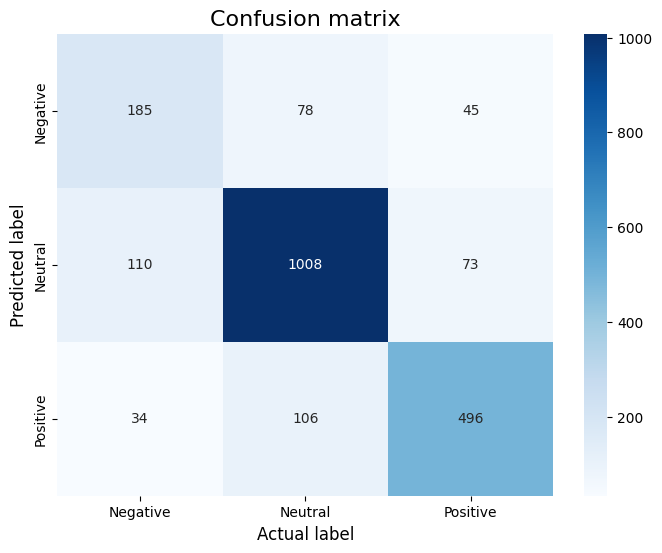

In [ ]:


def plot_confusion_matrix(model, X_test, y_test):
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [9]:
model = load_model("D:\\DocumentosI\\NGE\\NGE3.0+1.0\\The grid\\SA_FinancialNews.h5")

with open("tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)

In [18]:
df["title_en"].iloc[0]

'$ 20 tariff for imports under the 4x4 regime adds backs from productive sectors'

In [20]:
df["clean_text"] = df["title_en"].apply(basicalizer)

# Tokeniza y pad
seqs = tokenizer.texts_to_sequences(df["clean_text"])
padded_seqs = pad_sequences(seqs, maxlen=50, padding='post')

# Predice
preds = model.predict(padded_seqs)
df["pred_class"] = preds.argmax(axis=1)

# Etiquetas humanas
label_map = {0: "neutral", 1: "positive", 2: "negative"}
df["sentiment"] = df["pred_class"].map(label_map)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [23]:
df[["title","sentiment"]].head()

,title,sentiment
0,Arancel de $ 20 para importaciones bajo el ré...,neutral
1,Inversiones mineras: Hasta $ 53 millones al an...,neutral
2,Aceptada demanda a resolución que dispone no ...,neutral
3,Couriers no dan información de forma de cobro...,neutral
4,"Régimen 4x4: Compras de Temu, Shein, Amazon y...",positive


In [ ]:
model.save("SA_FinNews.h5")